# Test of Find PSF Candidates

This notebook tests an algorithm that first finds hot pixels by demanding that they
(a) exceed a threshold and (b) be brighter than their four nearest neighbors. These 
are the &ldquo;hot pixel leaders.&rdquo

Then it culls the hot pixel leaders whose neighbors fall off too sharply using the following
quick criterion for non-PSF-shaped regions: any hot pixel leader that has a neighbor <20% of
the peak is not a PSF candidate.

## Create the Test Data

In [1]:
# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.

import numpy as np
import matplotlib.pyplot as plt
from math import floor
%matplotlib inline

TEST_DATA_WIDTH = 6
TEST_DATA_HEIGHT = 4

TEST_DATA = np.zeros((TEST_DATA_HEIGHT, TEST_DATA_WIDTH))

#       0   1   2   3   4   5 
#   3  025 250 025 075 200 225
#   2  175 175 050 125 250 200
#   1  300 250 000 175 275 125
#   0  275 000 000 000 075 050

NON_ZERO_PIXELS = [
    [0, 0, 275],
    [4, 0,  75],
    [5, 0,  50],
    [0, 1, 300], # Almost a PSF candidate, but surrounding region isn't smooth
    [1, 1, 250],
    [3, 1, 175],
    [4, 1, 275], # A hot pixel leader that is not a candidate
    [5, 1, 125],
    [0, 2, 175],
    [1, 2, 175],
    [2, 2,  50],
    [3, 2, 125],
    [4, 2, 250],
    [5, 2, 200],
    [0, 3,  25],
    [1, 3, 250], # Almost a PSF candidate, but surrounding region isn't smooth
    [2, 3,  25],
    [3, 3,  75],
    [4, 3, 200],
    [5, 3, 225], # PSF candidate!
]

for row in NON_ZERO_PIXELS:
    TEST_DATA[row[1], row[0]] = row[2]


## Routines for Enumerating Neighbors

In [2]:
from collections import namedtuple

Pixel = namedtuple('Pixel', 'x y value')

# Each of these routines may return fewer neighbors if the pixel is near the edge

def __get_neighbors(pixel, offsets, data):
    data_height, data_width = data.shape
    neighbors = []
    for offset_x, offset_y in offsets:
        x = pixel.x + offset_x
        y = pixel.y + offset_y
        if x < 0 or y < 0 or x >= data_width or y >= data_height:
            continue
        neighbors.append(Pixel(x, y, data[y, x]))
    return neighbors

def get_four_neighbors(pixel, data):
    offsets = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    return __get_neighbors(pixel, offsets, data)

def get_eight_neighbors(pixel, data):
    offsets = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
    return __get_neighbors(pixel, offsets, data)

def get_twelve_second_neighbors(pixel, data):
    offsets = [(-2, 0), (-2, 1), (-1, 2), (0, 2), (1, 2), (2, 1),
               (2, 0), (2, -1), (1, -2), (0, -2), (-1, -2), (-2, -1)]
    return __get_neighbors(pixel, offsets, data)

def get_sixteen_second_neighbors(pixel, data):
    offsets = [(-2, 0), (-2, 1), (-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2), (2, 1),
               (2, 0), (2, -1), (2, -2), (1, -2), (0, -2), (-1, -2), (-2, -2), (-2, -1)]
    return __get_neighbors(pixel, offsets, data)


## Routines for Finding Hot Pixel Leaders

In [3]:
def is_winner_or_tied(candidate_leader, neighbor):
    return candidate_leader.value >= neighbor.value

def is_leader(candidate_leader, data):
    four_neighbors = get_four_neighbors(candidate_leader, data)
    for neighbor in four_neighbors:
        if not is_winner_or_tied(candidate_leader, neighbor):
            return False
    return True

def find_hot_pixel_leaders(data, threshold):
    # first we simply find all the hot pixels
    data_height, data_width = data.shape
    exceedances = data > threshold  # an array of true-false values
    values_of_exceedances = data[exceedances]
    exceedance_indices = np.nonzero(exceedances)  # a crafty way of getting the indices of the exceedances
    # all of the hot pixels are candidate leaders
    candidate_leaders = np.transpose([exceedance_indices[1], exceedance_indices[0], values_of_exceedances])
    leaders = []
    for i in range(candidate_leaders.shape[0]):
        row = candidate_leaders[i]
        candidate_leader = Pixel(floor(row[0]), floor(row[1]), row[2])
        if is_leader(candidate_leader, data):
            leaders.append(candidate_leader)
    return leaders


## Find the Hot Pixel Leaders

In [4]:
hot_pixel_leaders = find_hot_pixel_leaders(TEST_DATA, 200)


## Routines for Finding PSF Candidates

In [5]:
def is_too_large(pixel, neighbor, ratio):
    return ratio * pixel.value > neighbor.value

def is_in_continuous_region(pixel, data, ratio, recurse=False):
    four_neighbors = get_four_neighbors(pixel, data)
    for neighbor in four_neighbors:
        if is_too_large(pixel, neighbor, ratio):
            return False
    if recurse:
        eight_neighbors = get_eight_neighbors(pixel, data)
        twelve_second_neighbors = get_twelve_second_neighbors(pixel, data)
        surrounding_region = eight_neighbors + twelve_second_neighbors
        for neighbor in surrounding_region:
            if not is_in_continuous_region(neighbor, data, ratio, recurse=False):
                return False
    return True

def find_psf_candidates(leaders, data, ratio):
    candidates = [leader for leader in leaders if is_in_continuous_region(leader, data, ratio, recurse=True)]
    return candidates


## Find the PSF Candidates

In [6]:
candidates = find_psf_candidates(hot_pixel_leaders, TEST_DATA, 0.2)


## Routine for Displaying PSF Candidates

In [7]:
DISPLAY_HALF_RANGE = 3
DISPLAY_FULL_RANGE = 2 * DISPLAY_HALF_RANGE + 1

def display_candidate(candidate, data):
    
    data_height, data_width = data.shape

    lower_x = floor(candidate.x - DISPLAY_HALF_RANGE)
    upper_x = floor(lower_x + DISPLAY_FULL_RANGE)
    slice_x = slice(lower_x, upper_x)
    lower_y = floor(candidate.y - DISPLAY_HALF_RANGE)
    upper_y = floor(lower_y + DISPLAY_FULL_RANGE)
    slice_y = slice(lower_y, upper_y)
    
    fig_size_x = 4
    fig_size_y = 4
    
    # a bit of fussy code for dealing with display near the edges
    # check x edges
    if (lower_x < 0):
        lower_x = 0
        fig_size_x *= upper_x / DISPLAY_FULL_RANGE
    elif (upper_x > data_width):
        upper_x = data_width
        fig_size_x *= (data_width - lower_x) / DISPLAY_FULL_RANGE
    # check y edges
    if (lower_y < 0):
        lower_y = 0
        fig_size_y *= upper_y / DISPLAY_FULL_RANGE
    elif (upper_y > data_height):
        upper_y = data_height
        fig_size_y *= (data_height - lower_y) / DISPLAY_FULL_RANGE

    fig, axes = plt.subplots(1, 1, figsize=(fig_size_x, fig_size_y))
    
    print("{} is a PSF candidate with neighbor values:".format(candidate))
    
    for offset_y, offset_x in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
        j = floor(candidate.y + offset_y)
        i = floor(candidate.x + offset_x)
        if j < 0 or j >= data_height or i < 0 or i >= data_width:
            continue
        print("    x={}, y={}, value={}".format(i, j, data[j][i]))
    
    title = "PSF candidate at ({}, {})".format(candidate.x, candidate.y)
    
    subframe = data[lower_y:upper_y, lower_x:upper_x]
    
    axes.imshow(subframe, cmap='gray')
    axes.set_title(title, fontsize=12)
    axes.set_xlabel('x')
    axes.set_ylabel('y')
    axes.invert_yaxis()
    
    xpositions = range(upper_x - lower_x)
    xlabels = [str(x + lower_x) for x in xpositions]
    ypositions = range(upper_y - lower_y)
    ylabels = [str(y + lower_y) for y in ypositions]
    
    axes.set_xticks(xpositions, xlabels)
    axes.set_yticks(ypositions, ylabels)
    
    plt.tight_layout()
    plt.show()


## Display the PSF Candidates

Pixel(x=5, y=3, value=225.0) is a PSF candidate with neighbor values:
    x=5, y=2, value=200.0
    x=4, y=3, value=200.0


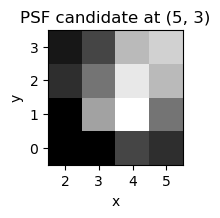

In [8]:
for candidate in candidates:
    display_candidate(candidate, TEST_DATA)
